In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PowerTransformer
import joblib




In [3]:
data = pd.read_csv("Cleaned_data.csv")


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35295 entries, 0 to 35294
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BorrState              35295 non-null  object 
 1   GrossApproval          35295 non-null  int64  
 2   SBAGuaranteedApproval  35295 non-null  float64
 3   ApprovalFiscalYear     35295 non-null  int64  
 4   loan_type              35295 non-null  object 
 5   InitialInterestRate    35295 non-null  float64
 6   TermInMonths           35295 non-null  int64  
 7   industry               35295 non-null  object 
 8   ProjectState           35295 non-null  object 
 9   BusinessType           35295 non-null  object 
 10  BusinessAge            35295 non-null  int64  
 11  LoanStatus             35295 non-null  object 
 12  GrossChargeOffAmount   35295 non-null  int64  
 13  RevolverStatus         35295 non-null  int64  
 14  Franchise              35295 non-null  int64  
dtypes:

In [4]:
    # deleteing  irelevant features for model building
data = data.drop(axis=1, columns=["BorrState", "ProjectState", "ApprovalFiscalYear"])


In [5]:
df = data.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35295 entries, 0 to 35294
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GrossApproval          35295 non-null  int64  
 1   SBAGuaranteedApproval  35295 non-null  float64
 2   loan_type              35295 non-null  object 
 3   InitialInterestRate    35295 non-null  float64
 4   TermInMonths           35295 non-null  int64  
 5   industry               35295 non-null  object 
 6   BusinessType           35295 non-null  object 
 7   BusinessAge            35295 non-null  int64  
 8   LoanStatus             35295 non-null  object 
 9   GrossChargeOffAmount   35295 non-null  int64  
 10  RevolverStatus         35295 non-null  int64  
 11  Franchise              35295 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 3.2+ MB


In [7]:
df.describe().T

count           mean            std     min      25%  \
GrossApproval          35295.0  368143.890069  710637.180682  2000.0  50000.0   
SBAGuaranteedApproval  35295.0  268805.535091  543191.870861  1000.0  25000.0   
InitialInterestRate    35295.0       7.397152       1.565764     1.0      6.4   
TermInMonths           35295.0     115.835472      73.168987     0.0     66.0   
BusinessAge            35295.0       1.864173       1.386421     0.0      2.0   
GrossChargeOffAmount   35295.0   12016.478000   70313.734307     0.0      0.0   
RevolverStatus         35295.0       0.309562       0.462320     0.0      0.0   
Franchise              35295.0       0.115115       0.319166     0.0      0.0   

                             50%       75%        max  
GrossApproval          115000.00  349650.0  5000000.0  
SBAGuaranteedApproval   75000.00  232500.0  4500000.0  
InitialInterestRate         7.25       8.0       13.5  
TermInMonths              119.00     120.0      324.0  
BusinessAge                 2.00       2.0        5.0  
GrossChargeOffAmount        0.00       0.0  4491269.0  
RevolverStatus              0.00       1.0        1.0  
Franchise                   0.00       0.0        1.0

In [15]:
def distp(df):
    plt.figure(figsize=(12, 12))
    for i, col in enumerate(df.select_dtypes(include=['float64','int64']).columns):
        plt.rcParams['axes.facecolor'] = 'white'
        ax = plt.subplot(9,2, i+1)
        sns.histplot(data=df, x=col, ax=ax,color='red',kde=True)
    plt.suptitle('Data distribution of continuous variables')
    plt.tight_layout()

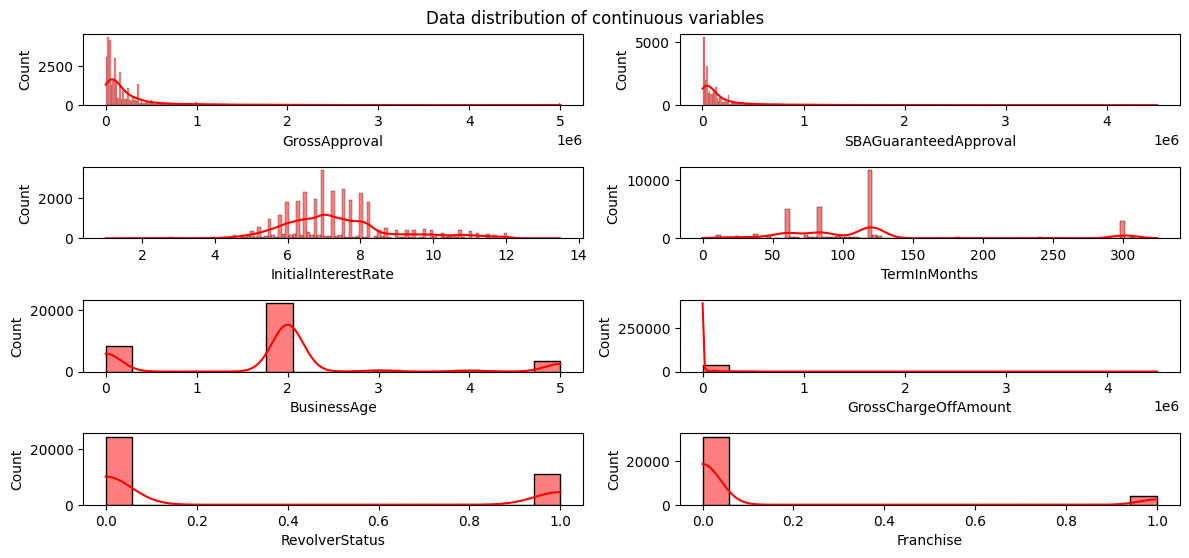

In [16]:
distp(df)

In [17]:
def boxp(df):
    plt.figure(figsize=(12, 12))
    for i, col in enumerate(df.select_dtypes(include=['float64','int64']).columns):
        plt.rcParams['axes.facecolor'] = 'white'
        ax = plt.subplot(9,2, i+1)
        sns.boxplot(data=df, x=col, ax=ax,color='blue')
    plt.suptitle('Box Plot of continuous variables')
    plt.tight_layout()

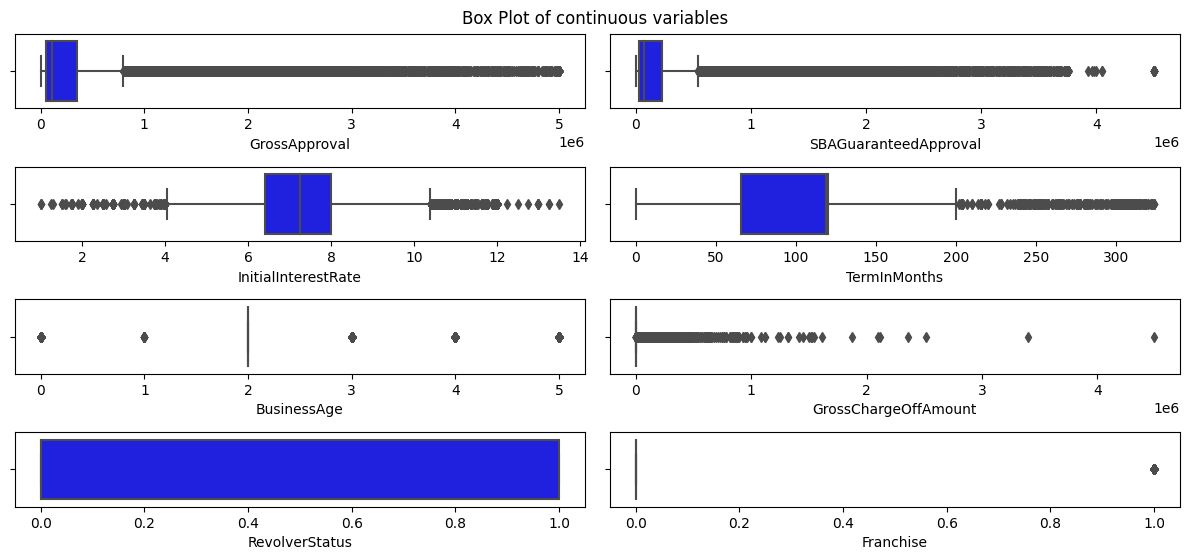

In [18]:
boxp(df)

# handling Outlires

In [19]:
def outlier_finder(df):
    df = df.select_dtypes(include=["int64","float64"])
    d = pd.DataFrame(columns= ["feature","outlier_present","number of outliers", "max outlier value"] )
 
    for feature in df:
        q1=df[feature].quantile(0.25)
        q3=df[feature].quantile(0.75)
        IQR=q3-q1
        L= q1-1.5*IQR
        U= q3+1.5*IQR
        outliers  = df[feature][(df[feature] < L ) | (df[feature] > U)]
      
        if len(outliers) > 0:
            d.loc[len(d.index)] = [feature,True,len(outliers), max(outliers)]
        else:
            d.loc[len(d.index)] = [feature,False,None , None]
 
    d.set_index("feature", inplace=True)
    return print(d)
     
    

In [20]:
outlier_finder(df)

                       outlier_present number of outliers  max outlier value
feature                                                                     
GrossApproval                     True               4124          5000000.0
SBAGuaranteedApproval             True               4470          4500000.0
InitialInterestRate               True               2546               13.5
TermInMonths                      True               4265              324.0
BusinessAge                       True              13010                5.0
GrossChargeOffAmount              True               3371          4491269.0
RevolverStatus                   False               None                NaN
Franchise                         True               4063                1.0


In [21]:
def outlire_capping(df):
    df1 = df.select_dtypes(include=["int64","float64"]) 
    for feature in df1:
        q1=df[feature].quantile(0.25)
        q3=df[feature].quantile(0.75)
        IQR=q3-q1
        L= q1-1.5*IQR
        U= q3+1.5*IQR
        df[feature] = df1[feature].apply(lambda x: L if x < L else (U if x > U else x))
    return df

In [22]:
df1  = outlire_capping(df)

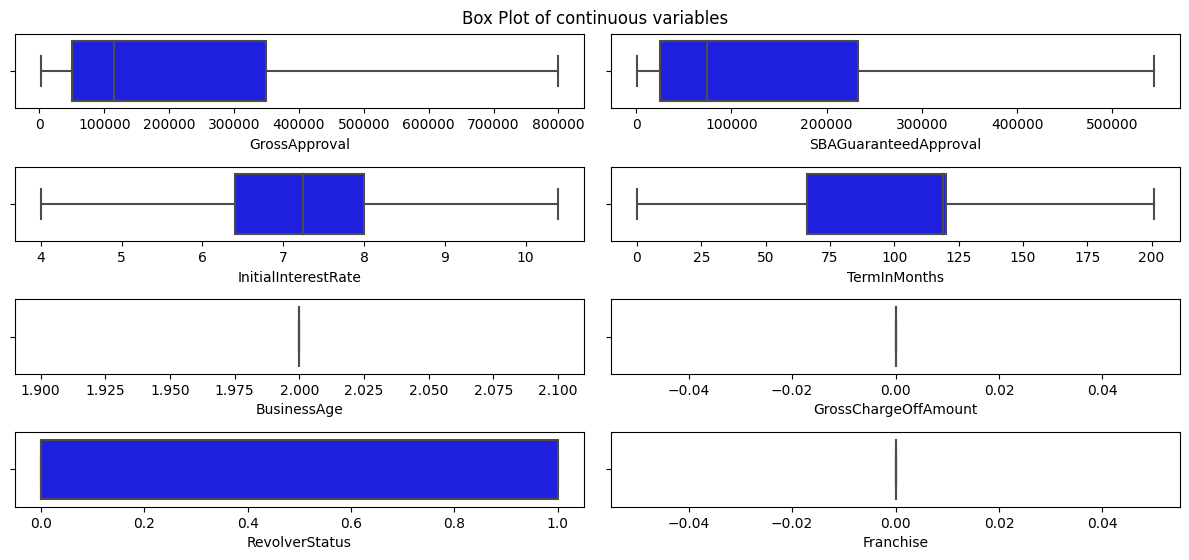

In [23]:
boxp(df1)

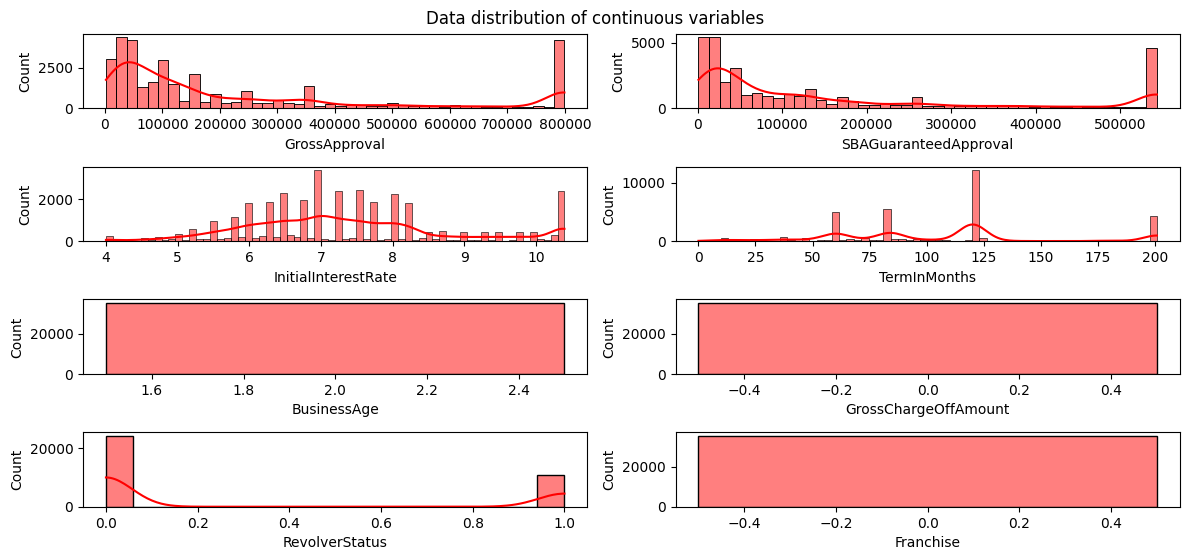

In [24]:
distp(df1)

In [25]:
outlier_finder(df1)

                       outlier_present number of outliers max outlier value
feature                                                                    
GrossApproval                    False               None              None
SBAGuaranteedApproval            False               None              None
InitialInterestRate              False               None              None
TermInMonths                     False               None              None
BusinessAge                      False               None              None
GrossChargeOffAmount             False               None              None
RevolverStatus                   False               None              None
Franchise                        False               None              None


# Normalizing and Standaizing the Data


In [26]:
def stand_norm(df):
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    df1 = pd.DataFrame(pt.fit_transform(df.select_dtypes(include=['float64','int64'])), columns=df.select_dtypes(include=['float64','int64']).columns)
    df2 = df.select_dtypes(object)
    df= pd.concat([df1, df2] , axis=1)
    return df

    


In [27]:
df2 = stand_norm(df1)

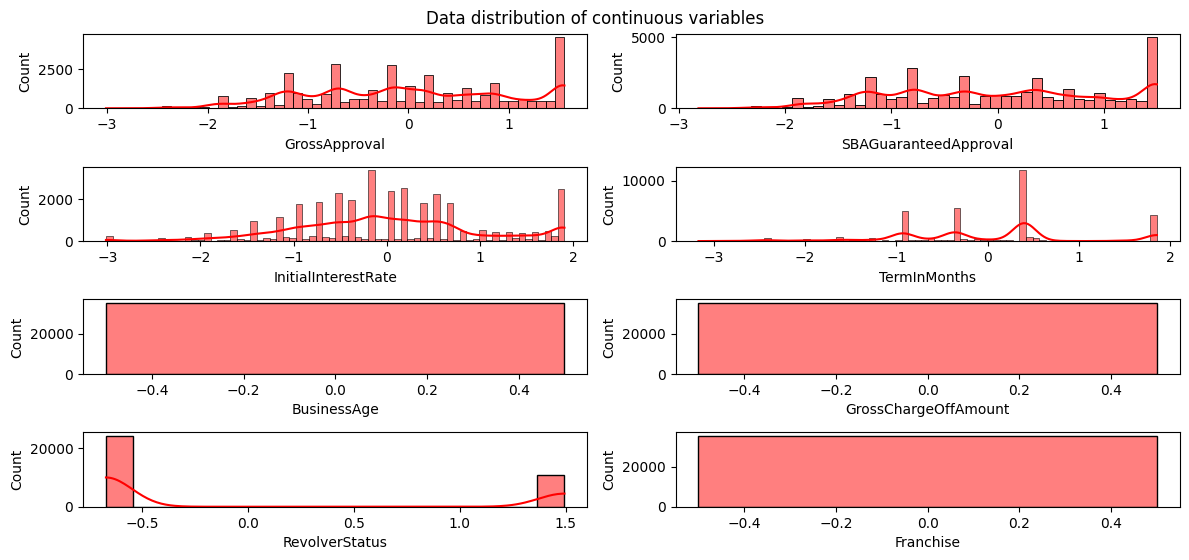

In [28]:
distp(df2)

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35295 entries, 0 to 35294
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GrossApproval          35295 non-null  float64
 1   SBAGuaranteedApproval  35295 non-null  float64
 2   InitialInterestRate    35295 non-null  float64
 3   TermInMonths           35295 non-null  float64
 4   BusinessAge            35295 non-null  float64
 5   GrossChargeOffAmount   35295 non-null  float64
 6   RevolverStatus         35295 non-null  float64
 7   Franchise              35295 non-null  float64
 8   loan_type              35295 non-null  object 
 9   industry               35295 non-null  object 
 10  BusinessType           35295 non-null  object 
 11  LoanStatus             35295 non-null  object 
dtypes: float64(8), object(4)
memory usage: 3.2+ MB


# final Data

In [30]:
df2.to_csv("preprocessed_data.csv", index=False)

# model deployment

In [13]:
#  as we  Normalizing and Standaizing the  Data, now we have to  ensure that the input data provided to your deployed model undergoes the same preprocessing.

# save the preprocessor (PowerTransformer)
x_train = df[["TermInMonths", "SBAGuaranteedApproval", "InitialInterestRate", "GrossApproval", "RevolverStatus"]]
preprocessor = PowerTransformer(method='yeo-johnson', standardize=True)
X_train_transformed = preprocessor.fit_transform(x_train)

joblib.dump(preprocessor, 'power_transformer.joblib')

['power_transformer.joblib']